# Figure 6

Figure 6. As in Figure 1, except for MCS precipitation and changes in MCS precipitation relative to HIST. 

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import xarray as xr

data_dir = "../data"
analysis='mcs_precip'
subset='annual'

simulation_names = {'historical': 'HIST', 
                    'future_4p5': 'EoC 4.5', 
                    'delta_future_4p5': '$\Delta$ EoC 4.5',
                    'future_8p5': 'EoC 8.5', 
                    'delta_future_8p5': '$\Delta$ EoC 8.5'}

annual_years = {}
annual_means = {}

for sim in simulation_names.keys():
    
    if sim in ['historical', 'future_4p5', 'future_8p5']:
        
        ds = xr.open_mfdataset(f"{data_dir}/{analysis}/{sim}_{subset}/*.nc")

        ds_annual = ds.resample(time='AS-OCT').sum('time')
        ds_annual = ds_annual.compute()

        ds_mean = ds_annual.mean('time')
    
        annual_years[sim] = ds_annual
        annual_means[sim] = ds_mean

        ds.close()
            
    else:
            
        futr_str = sim.replace("delta_", "")
                
        annual_means[sim] = annual_means[futr_str] - annual_means['historical']
        annual_years[sim] = None

### Draw map

<Figure size 3800x4000 with 0 Axes>

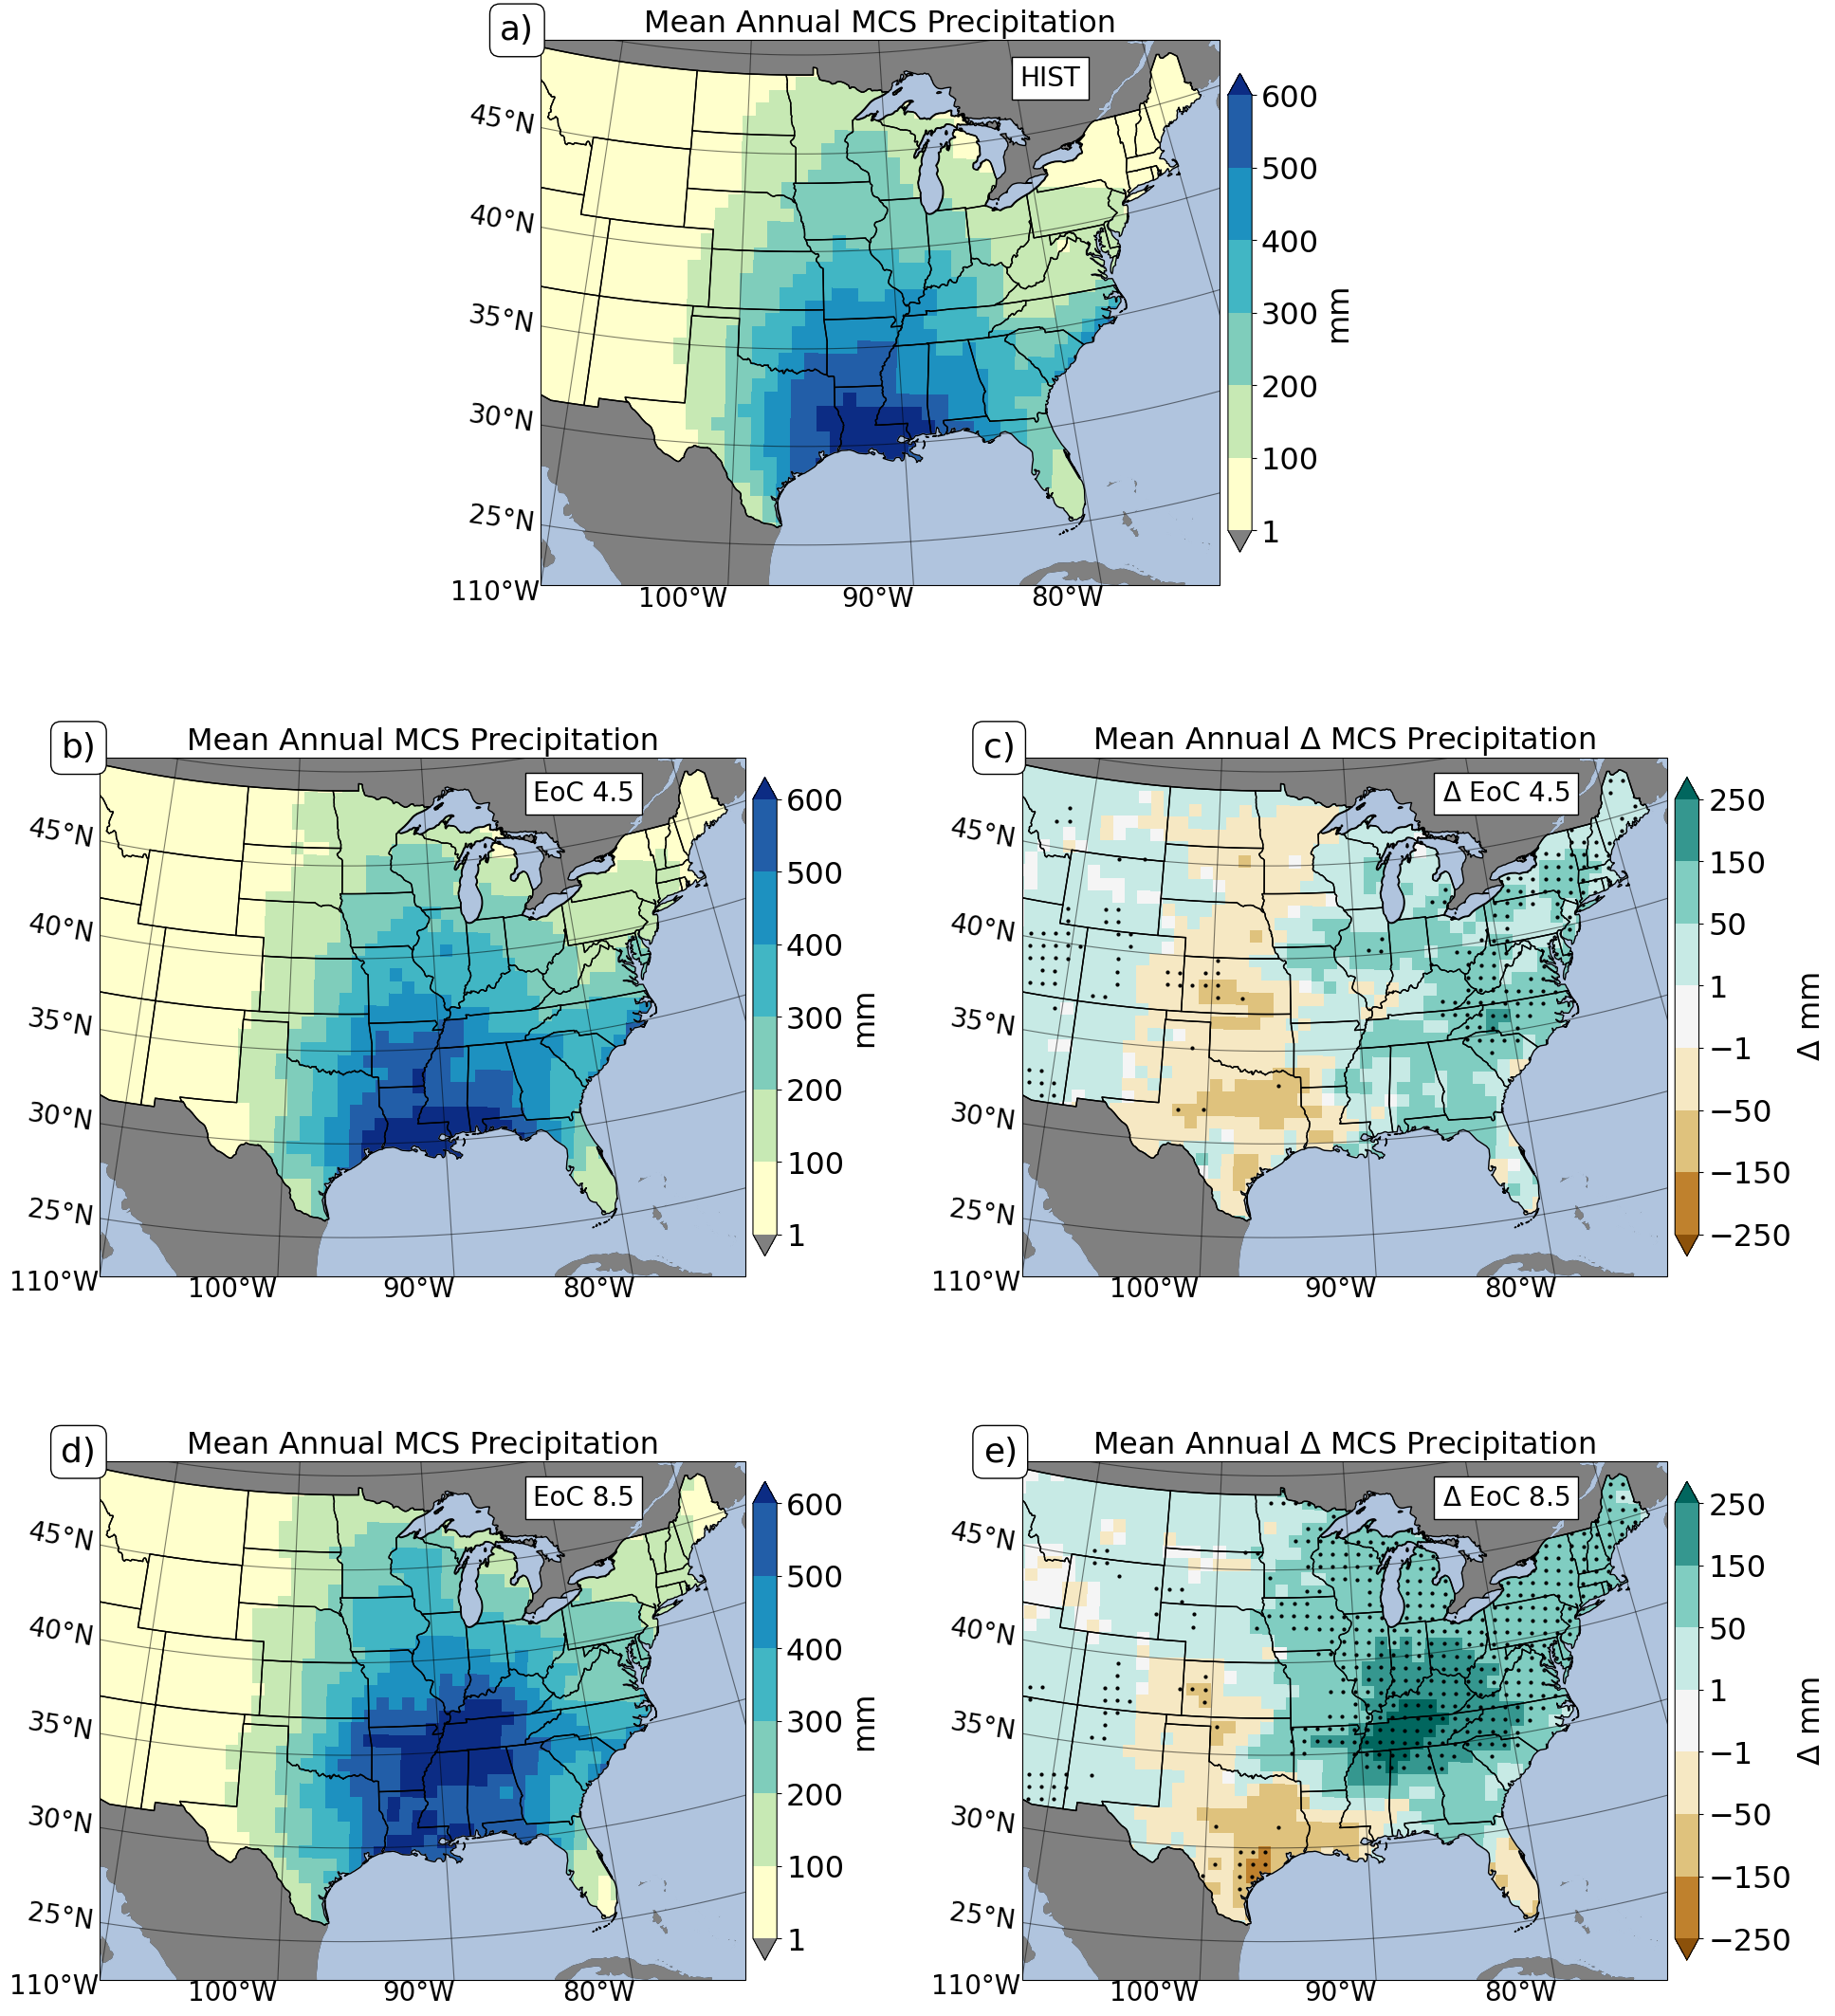

In [3]:
from mapping import setup_map, spec_ax, get_color_dict
from stats import grid_significance
import cartopy.crs as ccrs
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['xtick.labelsize'] = 23
plt.rcParams['ytick.labelsize'] = 23
plt.rcParams['axes.titlesize'] = 23
plt.rcParams['axes.labelsize'] = 23

color_info = get_color_dict(7)

fig = plt.figure(figsize=(38,40))

simulation_dispy = {'historical': 'HIST',
                    'future_4p5': 'EoC 4.5',
                    'delta_future_4p5': '$\Delta$ EoC 4.5',
                    'future_8p5': 'EoC 8.5',
                    'delta_future_8p5': '$\Delta$ EoC 8.5'}

fig = plt.figure(figsize=(23, 27))

for ax_pos, (sim_name, sim_abbr) in enumerate(simulation_dispy.items()):

    ax = spec_ax(ax_pos, nrows=3, ncols=4, fig=fig, five_panel=True)

    ax = setup_map(label_num=ax_pos+1, ax=ax, draw_outlines=False)
    
    ax.annotate(f"{sim_abbr}", (0.75,0.93), 
                xycoords='axes fraction', ha='center', va='center',
                fontsize=20, bbox=dict(boxstyle='square', facecolor='w', alpha=1), 
                color='k', zorder=25)

    mmp = ax.pcolormesh(annual_means[sim_name].lon, annual_means[sim_name].lat, 
                        annual_means[sim_name]['mcs_mask'],
                        transform=ccrs.PlateCarree(), 
                        cmap=color_info[sim_name]['cmap'], norm=color_info[sim_name]['norm'], zorder=5)

    cbar = plt.colorbar(mmp, ax=ax, shrink=0.85, extend='both', pad=0.01)
    
    if sim_name in ['historical', 'future_4p5', 'future_8p5']:

        ax.set_title("Mean Annual MCS Precipitation")
        
        cbar.set_label(label="mm")

    else:
        
        futr_str = sim_name.replace("delta_", "")
        
        ax.set_title("Mean Annual $\Delta$ MCS Precipitation")
        
        cbar.set_label(label="$\Delta$ mm")
        
        sig = grid_significance(annual_years['historical']['mcs_mask'].values, 
                                annual_years[futr_str]['mcs_mask'].values)

        pts_sig = np.where(sig < 0.05)

        ax.plot(annual_means['historical'].lon.values[pts_sig],
                annual_means['historical'].lat.values[pts_sig],
                transform=ccrs.PlateCarree(), zorder=5, linestyle='None', 
                marker='.', color='k', ms=4)
        
    ax.spines['geo'].set_zorder(24)
    
#plt.savefig("Figure_6.png", dpi=200, bbox_inches='tight')